In [28]:
#Downloading the dataset from kaggle
import kagglehub
path = kagglehub.dataset_download("prasanshasatpathy/soil-types")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/soil-types


In [29]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [30]:
# Setting seed for reproducibility
random.seed(42)
np.random.seed(42)

In [38]:
# Original dataset directory
original_dataset_dir = "/kaggle/input/soil-types/Soil types"

In [39]:
# Creating working directories
base_dir = "/kaggle/working/soil_dataset"
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

In [40]:
# Split data manually into train and validation (80-20)
split_ratio = 0.8
for class_name in os.listdir(original_dataset_dir):
    src_folder = os.path.join(original_dataset_dir, class_name)
    if os.path.isdir(src_folder):
        images = [f for f in os.listdir(src_folder) if os.path.isfile(os.path.join(src_folder, f))]
        random.shuffle(images)
        split = int(len(images) * split_ratio)
        train_imgs = images[:split]
        val_imgs = images[split:]

        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        for img in train_imgs:
            shutil.copy(os.path.join(src_folder, img), os.path.join(train_dir, class_name, img))
        for img in val_imgs:
            shutil.copy(os.path.join(src_folder, img), os.path.join(val_dir, class_name, img))

print("Dataset split completed.")

Dataset split completed.


In [41]:
# Parameters
img_size = (224, 224)
batch_size = 32

In [42]:
# Data generators with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    shear_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_directory(
    val_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 124 images belonging to 6 classes.
Found 32 images belonging to 6 classes.


In [44]:
# Transfer Learning Model MobileNetV2
base_model = MobileNetV2(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
#Freezing the base
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [45]:
# Callbacks
early_stop = EarlyStopping(patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(patience=3, factor=0.3, verbose=1)
checkpoint = ModelCheckpoint('best_soil_model.h5', save_best_only=True)

In [46]:
# Training
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[early_stop, reduce_lr, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1457 - loss: 2.6612   

4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 3s/step - accuracy: 0.1456 - loss: 2.6401 - val_accuracy: 0.1875 - val_loss: 1.9012 - learning_rate: 1.0000e-04
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.1754 - loss: 2.2636

4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 490ms/step - accuracy: 0.1806 - loss: 2.2567 - val_accuracy: 0.2812 - val_loss: 1.7911 - learning_rate: 1.0000e-04
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.2302 - loss: 2.1386

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 516ms/step - accuracy: 0.2277 - loss: 2.1332 - val_accuracy: 0.3125 - val_loss: 1.7271 - learning_rate: 1.0000e-04
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 555ms/step - accuracy: 0.2512 - loss: 1.8860

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 755ms/step - accuracy: 0.2445 - loss: 1.8919 - val_accuracy: 0.3750 - val_loss: 1.6695 - learning_rate: 1.0000e-04
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step - accuracy: 0.3194 - loss: 1.8629

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 488ms/step - accuracy: 0.3152 - loss: 1.8627 - val_accuracy: 0.3750 - val_loss: 1.6040 - learning_rate: 1.0000e-04
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.3092 - loss: 1.7870

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 483ms/step - accuracy: 0.3167 - loss: 1.7668 - val_accuracy: 0.3750 - val_loss: 1.5360 - learning_rate: 1.0000e-04
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.3721 - loss: 1.7384

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.3783 - loss: 1.7263 - val_accuracy: 0.4062 - val_loss: 1.4841 - learning_rate: 1.0000e-04
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.4075 - loss: 1.5651

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 483ms/step - accuracy: 0.4098 - loss: 1.5551 - val_accuracy: 0.3750 - val_loss: 1.4440 - learning_rate: 1.0000e-04
Epoch 9/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.3187 - loss: 1.7033

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step - accuracy: 0.3259 - loss: 1.6927 - val_accuracy: 0.4062 - val_loss: 1.4096 - learning_rate: 1.0000e-04
Epoch 10/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - accuracy: 0.2771 - loss: 1.5586

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 776ms/step - accuracy: 0.2830 - loss: 1.5626 - val_accuracy: 0.4062 - val_loss: 1.3877 - learning_rate: 1.0000e-04
Epoch 11/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.3542 - loss: 1.5614

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 495ms/step - accuracy: 0.3543 - loss: 1.5538 - val_accuracy: 0.3750 - val_loss: 1.3635 - learning_rate: 1.0000e-04
Epoch 12/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.5145 - loss: 1.3077

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 484ms/step - accuracy: 0.5100 - loss: 1.3121 - val_accuracy: 0.4688 - val_loss: 1.3426 - learning_rate: 1.0000e-04
Epoch 13/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step - accuracy: 0.4830 - loss: 1.3650

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step - accuracy: 0.4783 - loss: 1.3663 - val_accuracy: 0.4688 - val_loss: 1.3201 - learning_rate: 1.0000e-04
Epoch 14/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.4039 - loss: 1.4760

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 502ms/step - accuracy: 0.3973 - loss: 1.4743 - val_accuracy: 0.5000 - val_loss: 1.2986 - learning_rate: 1.0000e-04
Epoch 15/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step - accuracy: 0.4263 - loss: 1.3568

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.4297 - loss: 1.3452 - val_accuracy: 0.4375 - val_loss: 1.2815 - learning_rate: 1.0000e-04
Epoch 16/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.5243 - loss: 1.2648

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 733ms/step - accuracy: 0.5323 - loss: 1.2437 - val_accuracy: 0.5000 - val_loss: 1.2610 - learning_rate: 1.0000e-04
Epoch 17/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step - accuracy: 0.5263 - loss: 1.2264

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step - accuracy: 0.5275 - loss: 1.2241 - val_accuracy: 0.5000 - val_loss: 1.2446 - learning_rate: 1.0000e-04
Epoch 18/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step - accuracy: 0.4839 - loss: 1.2827

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 476ms/step - accuracy: 0.4855 - loss: 1.2831 - val_accuracy: 0.4688 - val_loss: 1.2302 - learning_rate: 1.0000e-04
Epoch 19/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.4866 - loss: 1.2463

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step - accuracy: 0.4925 - loss: 1.2323 - val_accuracy: 0.4688 - val_loss: 1.2155 - learning_rate: 1.0000e-04
Epoch 20/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step - accuracy: 0.5431 - loss: 1.0358

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 500ms/step - accuracy: 0.5393 - loss: 1.0487 - val_accuracy: 0.4688 - val_loss: 1.2011 - learning_rate: 1.0000e-04
Epoch 21/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 327ms/step - accuracy: 0.5769 - loss: 1.1079

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 485ms/step - accuracy: 0.5760 - loss: 1.1081 - val_accuracy: 0.4688 - val_loss: 1.1888 - learning_rate: 1.0000e-04
Epoch 22/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step - accuracy: 0.5407 - loss: 1.2194

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 648ms/step - accuracy: 0.5423 - loss: 1.2164 - val_accuracy: 0.4375 - val_loss: 1.1762 - learning_rate: 1.0000e-04
Epoch 23/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.6106 - loss: 1.0514

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 481ms/step - accuracy: 0.5965 - loss: 1.0688 - val_accuracy: 0.4688 - val_loss: 1.1671 - learning_rate: 1.0000e-04
Epoch 24/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.6466 - loss: 0.9277

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 499ms/step - accuracy: 0.6382 - loss: 0.9421 - val_accuracy: 0.5312 - val_loss: 1.1642 - learning_rate: 1.0000e-04
Epoch 25/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.5920 - loss: 1.0063

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 487ms/step - accuracy: 0.5913 - loss: 1.0151 - val_accuracy: 0.5000 - val_loss: 1.1636 - learning_rate: 1.0000e-04


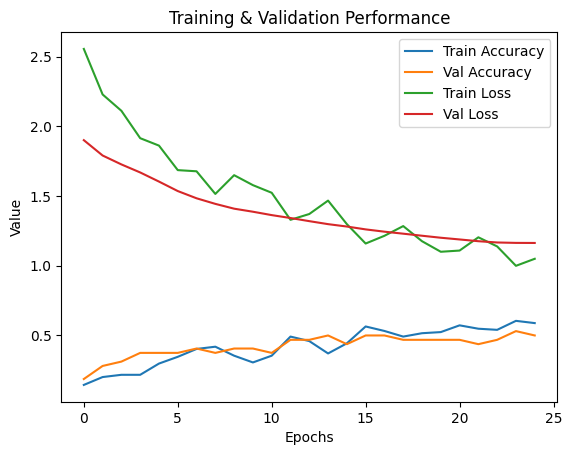

In [47]:
# Plotting
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Training & Validation Performance")
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.legend()
plt.show()